In [8]:
import numpy as np
import matplotlib.pyplot as plt

y = np.load('./TadGAN/original_1.npy')
y_hat = np.load('./TadGAN/hat_1.npy')

In [2]:
y = y.tolist()[0]

In [3]:
y_hat = y_hat.tolist()[0]

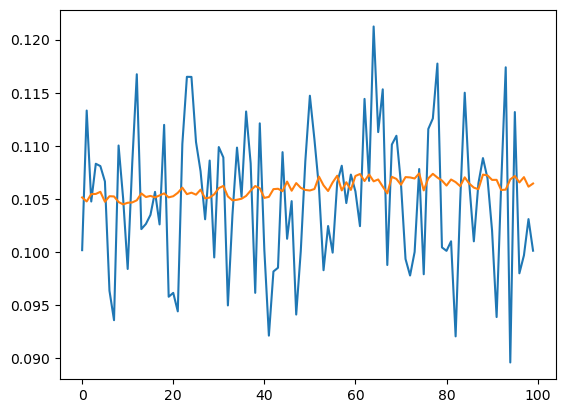

In [4]:
plt.plot(y)
plt.plot(y_hat)

In [ ]:
import csv
import pandas as pd
file = open('C:/Users/dk866/Desktop/bearing_test/data/set2_b1_outer_race_failure.csv')
reader = csv.reader(file)
l = list()

for row in reader:
    l.extend(list(map(float, row)))

bearing = pd.DataFrame(l)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[16, 4])
plt.plot(bearing)

In [70]:
import pandas as pd
bearing = pd.read_csv('C:/Users/dk866/Desktop/bearing_test/data/set2_b1_outer_race_failure.csv')


In [71]:
bearing.columns

Index(['Unnamed: 0', 'B1'], dtype='object')

In [72]:
bearing.columns = ['index','signal']

In [73]:
bearing['signal']

0          -0.042
1           0.015
2          -0.051
3          -0.107
4          -0.078
            ...  
20151331   -0.002
20151332   -0.002
20151333   -0.002
20151334   -0.002
20151335   -0.002
Name: signal, Length: 20151336, dtype: float64

In [79]:
df = bearing
df['anomaly'] = 0

In [80]:
df.columns

Index(['index', 'signal', 'anomaly'], dtype='object')

In [81]:
import numpy as np
window = 430
last = 0
signal = []
for i in range(1, len(bearing) // window):
    temp = np.sqrt(sum(bearing['signal'][last: i * window] ** 2) / window)
    signal.append(temp)
    last = i * window

df = pd.DataFrame()
df['signal'] = signal

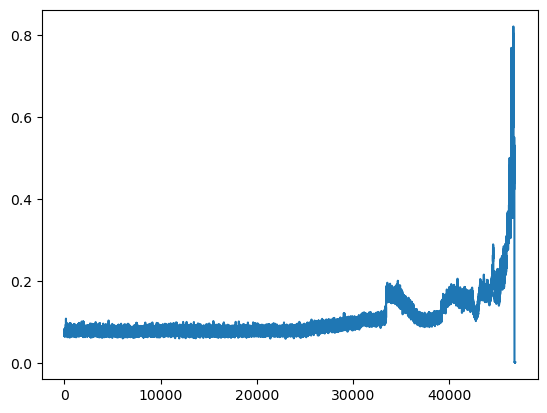

In [82]:
plt.plot(df['signal'])

In [83]:
df['signal'].shape

(46862,)

In [85]:
import torch
from TadGAN.model import Encoder, Decoder, CriticX, CriticZ

encoder = Encoder('./TadGAN/models/encoder.pt').to('cuda:0')
encoder.load_state_dict(torch.load('./TadGAN/models/record2-230508/encoder9.pt'))

decoder = Decoder('./TadGAN/models/decoder.pt').to('cuda:0')
decoder.load_state_dict(torch.load('./TadGAN/models/record2-230508/decoder9.pt'))

criticz = CriticZ('./TadGAN/models/critic_z.pt').to('cuda:0')
criticz.load_state_dict(torch.load('./TadGAN/models/record2-230508/critic_z9.pt'))
criticx = CriticX('./TadGAN/models/critic_x.pt').to('cuda:0')
criticx.load_state_dict(torch.load('./TadGAN/models/record2-230508/critic_x9.pt'))

<All keys matched successfully>

In [94]:
df['anomaly'] = 0

In [87]:
df = df.reset_index(drop=True)

In [88]:
class tester(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.columns = self.make_signal_list()
        self.make_rolling_signals()

    def make_signal_list(self):
        signal_list = list()
        for i in range(-50, 50):
            signal_list.append('signal'+str(i))
        return signal_list
        
    def make_rolling_signals(self) -> None:
        """
        Making dataset index as cycle
        """
        for i in range(-50, 50):
            self.dataset['signal'+str(i)] = self.dataset['signal'].shift(i)
        # drop NaN value and reset index
        self.dataset = self.dataset.dropna()
        self.dataset = self.dataset.reset_index(drop=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.loc[idx]
        x = row[self.columns].values.astype(float)
        x = torch.from_numpy(x)
        return {'signal': x, 'anomaly': row['anomaly']}

In [89]:
T = tester(df)
T.dataset.shape

C:\Users\dk866\AppData\Local\Temp\ipykernel_10540\3289213003.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.dataset['signal'+str(i)] = self.dataset['signal'].shift(i)


(46763, 101)

In [95]:
test_loader = torch.utils.data.DataLoader(tester(df), batch_size=64, drop_last=True) #, collate_fn=lambda x: default_collate(x).to(device))

In [91]:
print(test_loader)

In [96]:
reconstruction_list = list()
for batch, sample in enumerate(test_loader):
    print(len(sample['signal'][0]))
    reconstruction_signal = decoder(encoder(sample['signal']))
    reconstruction_signal = torch.squeeze(reconstruction_signal)
    reconstruction_list.extend(reconstruction_signal.detach().cpu().numpy())
    print(reconstruction_signal.shape)

100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Si

In [97]:
reconstruction_list = pd.DataFrame(reconstruction_list)

In [98]:
reconstruction_list.head

<bound method NDFrame.head of              0         1         2         3         4         5         6   \
0      0.070262  0.071124  0.070755  0.070692  0.070406  0.070482  0.071033   
1      0.070030  0.070921  0.070421  0.070456  0.070182  0.070128  0.070486   
2      0.070464  0.071180  0.070829  0.070713  0.070509  0.070537  0.070897   
3      0.070573  0.071423  0.071004  0.070886  0.070698  0.070736  0.071265   
4      0.070942  0.071640  0.071358  0.071076  0.070998  0.071090  0.071655   
...         ...       ...       ...       ...       ...       ...       ...   
46715  0.030609  0.021670  0.013408  0.017289  0.020883  0.000221 -0.039710   
46716  0.038255  0.032644  0.023199  0.026299  0.033660  0.012409 -0.033821   
46717  0.041215  0.038598  0.027839  0.031236  0.039933  0.018920 -0.029726   
46718  0.045602  0.046058  0.033185  0.036608  0.047445  0.026593 -0.025821   
46719  0.049108  0.053615  0.039323  0.043075  0.054228  0.034526 -0.017311   

             7       

In [193]:
df['signal']

0        0.024780
1        0.023178
2        0.024118
3        0.024496
4        0.023900
           ...   
69688    0.024643
69689    0.024049
69690    0.024446
69691    0.024029
69692    0.023684
Name: signal, Length: 69693, dtype: float64

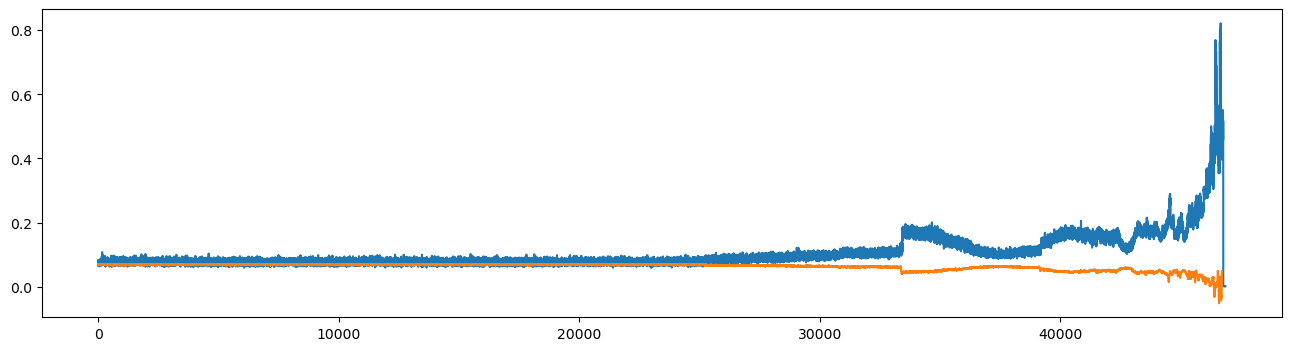

In [99]:
# epoch 0
plt.figure(figsize=[16, 4])
plt.plot(df['signal'])
plt.plot(reconstruction_list[0])
# plt.plot(bearing['signal'])